# TensorFlow Graph
TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

### TensorFlow Graph
1. Automatically <font color='red'>calculate the gradients</font>
2. The graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated <font color='red'>using the chain-rule</font> for derivatives.
3. TensorFlow takes advantage of multi-core CPUs as well as GPUs and TPUs (Tensor Processing Units) 

A TensorFlow graph consists of the following parts which will be detailed below:
* <font color='red'>Placeholder</font> variables used for inputting data to the graph.
* <font color='red'>Variables</font> that are going to be <font color='red'>optimized</font> so as to make the convolutional network perform better.
* A <font color='red'>cost measure</font> that can be used to guide the <font color='red'>optimization</font> of the variables.

# MNIST CNN
This is a practice/notes of MNIST with CNN. Following example from: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
## Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
from tensorflow.examples.tutorials.mnist import input_data


## Load Data

In [2]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)
print("Loaded Data...")
print("Training Size:\t\t{}".format(len(data.train.labels)))
print("Test Size:\t\t{}".format(len(data.test.labels)))
print("Validation Size:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Loaded Data...
Training Size:		55000
Test Size:		10000
Validation Size:	5000


## Setting Variables

In [3]:
#From One-Hot Encoding(labels) to class(cls) 
data.test.cls = np.argmax(data.test.labels, axis=1)

# MNIST images are 28 x 28 pixels
img_size = 28

# Flatten Image to one dimension
img_size_flat = img_size * img_size

# Original Image Shape for reshaping
img_shape = (img_size, img_size)

# We use Batch Gradient Descent to reduce the memories and time for calculating the gradient of each iteration.
train_batch_size = 50

# Num. of classes, 10 digits = 10 classes
num_classes = 10

# Num. of colour channels, MNIST is gray-scale = 1
num_channels = 1

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Learning rate
learning_rate = 1e-4

### Placeholder variables
Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute(feeding) the graph.

First we define the placeholder variable for the input images, we can feed different image set for each execution. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

In [4]:
# Flattened X 
# Output: [arbitrary, img_height * img_width * num_channels]
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

# TensorFlow expect 4-dim input X, so we have to reshape x
# Output: [num_images, img_height, img_width, num_channels]
# Note that all input is square, thus, img_height == img_width == img_size
# num_images can be inferred automatically by using -1 
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# Label y associated with X 
# Output: [arbitrary, num_classes]
# 10 classes for eachd digit in this case
# Each example's class is represent in vector e.g. For class 5 = [0,0,0,0,0,1,0,0,0,0]
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

# Class-number y associated with X 
# Output: [arbitrary]
# Each example's class is represent in number e.g. [5]
y_true_cls = tf.argmax(y_true, dimension=1)

# Helper Function
In ipython there is execution sequence, so all helper function should be execute before proceed.
<br>
**Note that the initialization is not actually done at this point, it defines the TensorFlow graph.

In [5]:
weight_no = 1
def new_weights(shape):
    global weight_no
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    tf.summary.histogram("w_" + `weight_no`, weights)
    weight_no += 1
    return weights

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function - Creating a new Convolutional Layer
Function creates a <font color='red'>new convolutional layer</font> in the computational graph for TensorFlow.
<br>Assumed the input is a 4-dim tensor with the following dimensions:
<ol>
<li>Image number</li>
<li>Y-axis of each image</li>
<li>X-axis of each image</li>
<li>Channels of each image(Colour-channels / filter-channels)</li>
</ol>
The output is another 4-dim tensor with the following dimensions:
<ol>
<li>Image number, same as input</li>
<li>Y-axis of each image </li>
<li>X-axis of each image</li>
( If 2x2 pooling is used, then the height and width of the input images is divided by 2 )
<li>Channels produced by the convolutional filters</li>
</ol>

In [6]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights, for filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    
    # Create the TensorFlow operation for convolution.
    #
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    #
    # Possible values for padding 'SAME', 'VALID'
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Rectified Linear Unit (ReLU). One type of Activation Function
    # Setting values < 0 to 0
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        # The setting [1,2,2,1] and padding = 'SAME' is the same as
        # the conv-layer above for the similar reason.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### Helper-function - Flattening a layer (im2col)
Function to reduce the 4-dim tensor (from conv-layer) to 2-dim which can be used as input to the fully-connected layer.

In [7]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    
    # layer_shape == [num_images, img_height, img_width, num_channels]
    # The number of features is: img_height * img_width * num_channels
    # From TensorFlow num_elements() is used to calculate num of features.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Helper-function - Creating a new Fully-Connected Layer
Function creates a <font color='red'>new fully-connected layer</font> in the computational graph for TensorFlow.

It is assumed that the input is a 2-dim tensor of shape [num_images, num_inputs]. The output is a 2-dim tensor of shape [num_images, num_outputs].

In [8]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU to add non-linearity
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Helper-function - Plotting example images
Function for showing some example images from the dataset along with its label

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

### Helper-function - Plot example errors
Function for plotting examples of images from the test-set that have been mis-classified.

In [10]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function - Plot confusion matrix
Function for plotting the confusion matrix, a table of "Classes vs Classes". Visualise how often one class of image being misclassified as another particular class.

In [11]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function - Showing the performance
Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [12]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

# Architecture (CNN part)
This part is the implementation of the whole CNN feeding MNIST dataset to identify 10 classes of hand-written digits.

CNN-Architecture: <br>
Conv1 - Conv2 - Flatten - FC1 - FC2 - Output(Softmax)

### Convolutional Layer 1
Create the first convolutional layer. <br>
It takes <b>x_image</b> [num_images, img_height, img_width, num_channels] as input and creates <b>num_filters1</b> different filters, each having width and height equal to <b>filter_size1</b>. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.


In [13]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

### Convolutional Layer 2
Create the second convolutional layer.<br>
It takes the output from the first convolutional layer <b>layer_conv1</b> as input. The number of input channels corresponds to <b>num_filters1</b>. Creates <b>num_filters2</b> different filters, each having width and height equal to <b>filter_size2</b>.

In [14]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

### Flatten Layer
The convolutional layers output 4-dim tensors [num_images, img_height, img_width, num_channels]. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors [arbitrary, num_features].

In [15]:
layer_flat, num_features = flatten_layer(layer_conv2)

### Fully-Connected Layer 1 (FC1)
Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is <b>fc_size</b>. ReLU is used so we can learn non-linear relations.

In [16]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

### Fully-Connected Layer 2 (FC2)
Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [17]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

### Softmax (Predicted Class)
<b>FC2</b> outputs how likely the image belongs to each of the 10 digit classes. However, the range of the values may be very small or large, thus normalisation is required. In this case, Softmax is used to convert these values to probabilistic values for prediction and stored in <b>y_pred</b>.

In [18]:
# Class vector e.g. For class 5 = [0,0,0,0,0,1,0,0,0,0] 
y_pred = tf.nn.softmax(layer_fc2)
# Use argmax to convert y from class vector to class labels e.g. 5
y_pred_cls = tf.argmax(y_pred, dimension=1)

# Architecture (Optimisation Part)

### Cost-function to be optimised
We want the model to perform better at classifying the input images, this can be achieve by updating the weights of all layers. But first, we have to measure how well the model currently performs by comparing <b>y_pred</b> (Prediected output) to <b>y_true</b> (Actual output).

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to <font color="red">minimize the cross-entropy</font> so it gets as <font color="red">close to zero</font> as possible by changing the variables of the network layers.

TensorFlow has a built-in function for calculating the cross-entropy. Note that <font color="red">the function calculates the softmax internally</font> so we must use the output of <b>layer_fc2</b> directly rather than <b>y_pred</b> which has already had the softmax applied.


In [19]:
# Using Logistic Cost Function
# - [y * log(h(x)) + (1-y) * log(1-h(x))]
# A cost is output for each image
# Output: [num of image,]
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)
# Computes the mean of all cost, resulting a single value
cost = tf.reduce_mean(cross_entropy)
# Collecting accuracy for TensorBoard
tf.summary.scalar("cost", cost)

<tf.Tensor 'cost:0' shape=() dtype=string>

### Optimization Method
AdamOptimizer which is an advanced form of Gradient Descent we can use for minimise the cost.
<br>
**Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

### Performance Measures
We need a few more performance measures to display the progress to the user.
This is a vector of booleans whether the predicted class equals the true class of each image.

In [21]:
# Vector of booleans whether the predicted class equals the true class of each image.
# Output: [num of image,]
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# Cast booleans to floats, False = 0, True = 1
# Calculate the average of these number
# Output: float32
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Collecting accuracy for TensorBoard
tf.summary.scalar("accuracy", accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

# Main (Execute)

In [29]:
# Create TensorFlow Session to execute the TensorFlow graph
session = tf.Session()
# Collecting accuracy for TensorBoard
# Summaries such as scalars can be seen by running the command below
# tensorboard --logdir="./log"
# http://192.168.0.150:6006
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./log', session.graph)
# Initialise weights and bias
session.run(tf.global_variables_initializer())


### Executing-function - Perform optimization iterations
This function is called to execute the training process of CNN. A number of optimization iterations so as to gradually improve the variables of the network layers. Each iteration, new batch of data is selected from the training-set and TensorFlow executes the optimizer using them. 

Input:<br>
num_iterations - Number of optimization iterations<br>
Output:<br>
None<br>
*weights is updated with-in the model and message of <b>Training Accuracy</b> is printed every 100 iterations

In [30]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure updating the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations, total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch - batch of image
        # y_true_batch - labels of x_batch
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # !!! Add [merged, opt] for TensorBoard !!! Very Important
        summary, _ = session.run([merged, optimizer], feed_dict=feed_dict_train)
        # Add summary to TensorBoard
        writer.add_summary(summary, i)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [31]:
optimize(num_iterations=1000)

Optimization Iteration:      1, Training Accuracy:   2.0%
Optimization Iteration:    101, Training Accuracy:  58.0%
Optimization Iteration:    201, Training Accuracy:  76.0%
Optimization Iteration:    301, Training Accuracy:  74.0%
Optimization Iteration:    401, Training Accuracy:  86.0%
Optimization Iteration:    501, Training Accuracy:  92.0%
Optimization Iteration:    601, Training Accuracy:  92.0%
Optimization Iteration:    701, Training Accuracy:  92.0%
Optimization Iteration:    801, Training Accuracy:  96.0%
Optimization Iteration:    901, Training Accuracy:  96.0%
Time usage: 0:00:41


### Visualising TensorFlow Graph
From: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [43]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [44]:
show_graph(tf.get_default_graph().as_graph_def())

Accuracy on Test-Set: 93.4% (9336 / 10000)
Example errors:


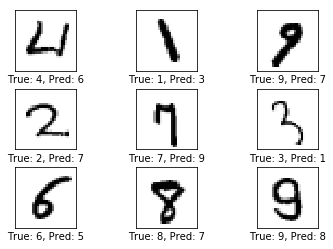

Confusion Matrix:
[[ 962    0    3    1    0    2    5    2    5    0]
 [   0 1110    4    4    0    1    3    0   13    0]
 [  14    2  952   12   12    1    4   20   15    0]
 [   2    5   15  934    0   12    0   27   11    4]
 [   1    1    4    0  929    0   11    3    2   31]
 [   8    3    4   31    7  810   12    4    7    6]
 [  12    4    2    0    7   18  912    0    3    0]
 [   2    6   23    1    4    1    0  968    2   21]
 [   9    5   10   25   12   13    7   20  858   15]
 [  11    5    6   10   27    5    0   40    4  901]]


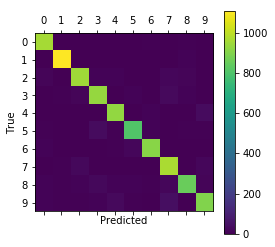

In [26]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Helper-function - Plotting convolutional weights
<font color="red">Require TensorFlow session</font>

In [29]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function - Plotting the output of a convolutional layer
<font color="red">Require TensorFlow session</font>

In [30]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

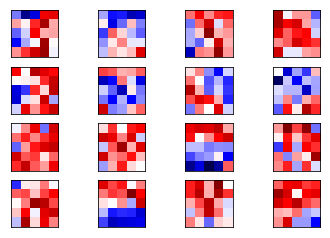

In [31]:
plot_conv_weights(weights=weights_conv1)

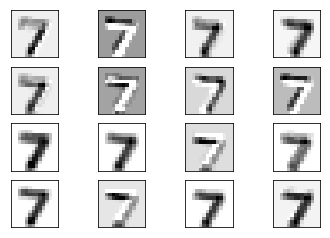

In [32]:
image1 = data.test.images[0]
plot_conv_layer(layer=layer_conv1, image=image1)
